In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import SimpleITK as sitk
%matplotlib inline

In [2]:
from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))   

In [3]:
ACE_PATH = "Z:/Virtual_Contrast_Data/Train/ACE/"
NCE_PATH = "Z:/Virtual_Contrast_Data/Train/NCE/"

ACE_list = os.listdir(ACE_PATH)
NCE_list = os.listdir(NCE_PATH)

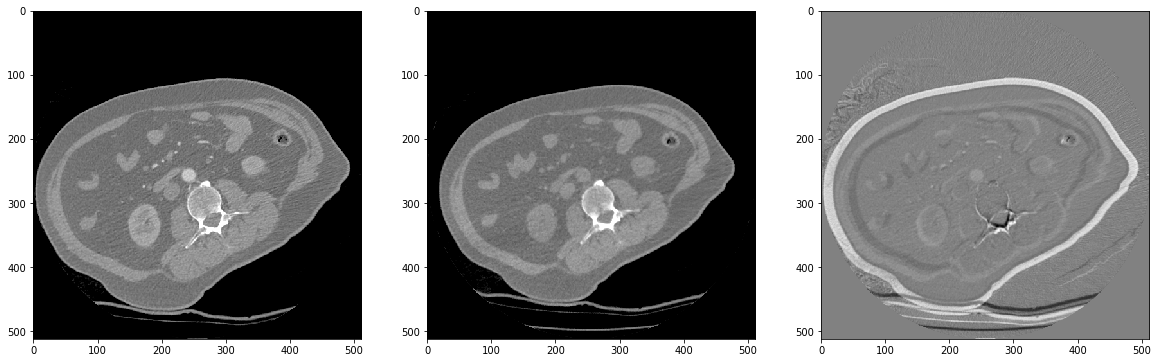

In [4]:
ACE = np.load(ACE_PATH + ACE_list[6])
NCE = np.load(NCE_PATH + NCE_list[6])

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(ACE[:, :, 10], cmap='gray', vmin=0.12, vmax=0.18)
axs[1].imshow(NCE[:, :, 10], cmap='gray', vmin=0.12, vmax=0.18)
axs[2].imshow(ACE[:, :, 10] - NCE[:, :, 10], cmap='gray')

plt.show()

In [32]:
fixed_image = sitk.GetImageFromArray(ACE)
moving_image = sitk.GetImageFromArray(NCE)

interact(
    display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1),
    moving_image_z=(0,moving_image.GetSize()[2]-1),
    fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)),
    moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Similarity3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interactive(children=(IntSlider(value=255, description='fixed_image_z', max=511), IntSlider(value=255, descrip…

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Similarity3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

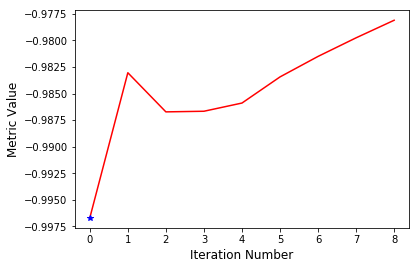

In [33]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()
           
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
# registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.SetInitialTransform(initial_transform, inPlace=False)

registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))

In [34]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.9758492924886334
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [35]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
WARP = sitk.GetArrayFromImage(moving_resampled)


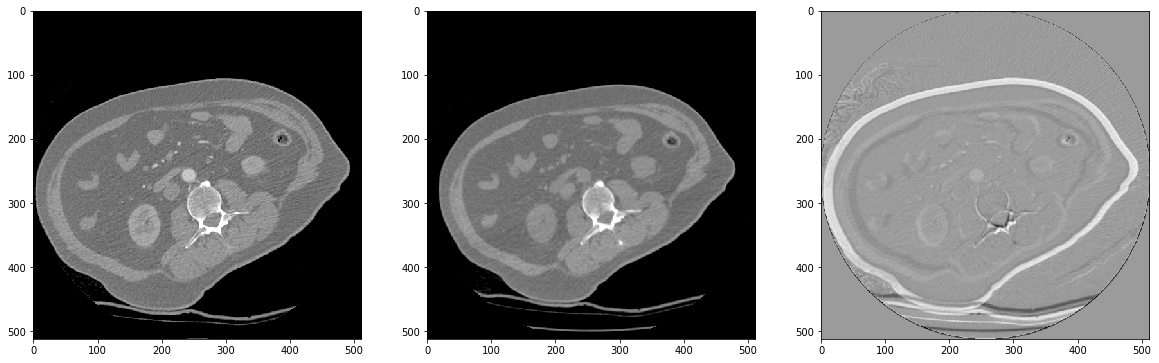

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(ACE[:, :, 10], cmap='gray', vmin=0.12, vmax=0.18)
axs[1].imshow(WARP[:, :, 10], cmap='gray', vmin=0.12, vmax=0.18)
axs[2].imshow(ACE[:, :, 10] - WARP[:, :, 10], cmap='gray')

plt.show()